In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

Task 1: Basics

In [2]:
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
resnet34.eval().cuda()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 210MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This defines the standard normalization parameters used for ImageNet models like ResNet-34. The mean_norms and std_norms arrays represent the per-channel mean and standard deviation values computed over the entire ImageNet training set. These values are necessary because the pretrained ResNet-34 model expects input images to have the same statistical distribution as the data it was originally trained on.

The plain_transforms pipeline first converts raw images into PyTorch tensors using transforms.ToTensor() and then normalizes them channel-wise using the provided mean and standard deviation. This preprocessing step is essential to ensure consistent model performance during inference.

In [3]:
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

This block loads the test dataset and prepares it for evaluation. The labels_list.json file is opened and parsed to create a mapping (local_to_imagenet) from the local class indices (as assigned by ImageFolder) to the actual 1000-class ImageNet indices expected by the pretrained model. Each entry in the JSON file is a string like "409:n02085936 Labrador_retriever", and the split(":")[0] extracts the numeric ImageNet ID.

After setting up the mapping, the dataset is loaded using ImageFolder, which assumes that each subdirectory in the test set corresponds to a class. The plain_transforms defined earlier are applied to each image. A DataLoader is created to serve the dataset in batches of 32 images. Finally, a pretrained ResNet-34 model is loaded with ImageNet-1K weights and moved to GPU for fast inference.

In [4]:
with open("../input/testdataset/TestDataSet/labels_list.json", "r") as f:
    label_map = json.load(f)

# Create local-to-ImageNet index mapping
local_to_imagenet = {
    local_idx: int(entry.split(":")[0])
    for local_idx, entry in enumerate(label_map)
}

# Dataset and model (assuming plain_transforms is already defined)
dataset_path = "../input/testdataset/TestDataSet"
dataset = ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1').eval().cuda()

This block performs the actual evaluation of the model on the test dataset. It initializes counters to keep track of Top-1 and Top-5 accuracy. The model is explicitly set to evaluation mode and used within a torch.no_grad() context to disable gradient computation, which saves memory and improves performance.

For each batch of images, the inputs are passed through the model to obtain prediction scores. The model's top-5 predictions are extracted using topk(5, dim=1). The ground-truth labels from the dataset are then mapped to their corresponding ImageNet indices using local_to_imagenet. The Top-1 accuracy is computed by checking if the top prediction matches the true label, while the Top-5 accuracy checks whether the true label appears among the model's five highest-confidence predictions. After all batches are processed, the script prints out the final Top-1 and Top-5 accuracy scores over the entire dataset.

In [5]:
top1_correct = 0
top5_correct = 0
total = 0

resnet34.eval().cuda()

with torch.no_grad():
    for inputs, targets in tqdm(dataloader):
        inputs = inputs.cuda()
        outputs = resnet34(inputs)
        _, top5_preds = outputs.topk(5, dim=1)
        top1_preds = top5_preds[:, 0]

        # Map targets to ImageNet indices
        imagenet_targets = torch.tensor([
            local_to_imagenet[int(t)] for t in targets
        ]).to(inputs.device)

        top1_correct += (top1_preds == imagenet_targets).sum().item()
        top5_correct += sum([
            imagenet_targets[i].item() in top5_preds[i] for i in range(len(imagenet_targets))
        ])
        total += targets.size(0)

print(f"Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"Top-5 Accuracy: {top5_correct / total:.4f}")

100%|██████████| 16/16 [00:04<00:00,  3.24it/s]

Top-1 Accuracy: 0.7600
Top-5 Accuracy: 0.9420


Top-1 Accuracy of 76% means the model's most confident prediction was correct 3 out of 4 times while Top-5 Accuracy of 94.2% means that even if the model's top prediction is occasionally wrong, the correct label is almost always among its five best guesses.

Task 2: Pixel-wise attacks

This block sets up the environment for generating adversarial examples using the Fast Gradient Sign Method (FGSM). The epsilon = 0.02 defines the L∞ perturbation constraint — meaning each pixel can be changed by at most 2% of its full intensity range, which keeps the adversarial examples visually similar to the originals.

Normalization parameters (mean_norms, std_norms) are defined in PyTorch tensor format and moved to the GPU to match the model input format. The preprocessing pipeline includes resizing, center cropping (standard for ImageNet), and conversion to tensor, preparing the images for ResNet input.

The dataset is loaded from the original test set using ImageFolder, and a label map is parsed from the labels_list.json, which contains class indices and their corresponding ImageNet labels. A local_to_imagenet dictionary is constructed to map class indices used locally in this test set to their true ImageNet indices — a critical step for correct evaluation. Finally, an output directory is created to store the 500 adversarial images, and vis_images is initialized to store examples for later visualization.

In [6]:
epsilon = 0.02

mean_norms = torch.tensor([0.485, 0.456, 0.406]).cuda().view(3, 1, 1)
std_norms = torch.tensor([0.229, 0.224, 0.225]).cuda().view(3, 1, 1)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

dataset_path = "../input/testdataset/TestDataSet"
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Load labels
with open(f"{dataset_path}/labels_list.json", "r") as f:
    label_map = json.load(f)

local_to_imagenet = {
    local_idx: int(entry.split(":")[0])
    for local_idx, entry in enumerate(label_map)
}

output_dir = "./AdversarialTestSet1"
os.makedirs(output_dir, exist_ok=True)

vis_images = []


This block performs the core FGSM attack and evaluates the perturbed images.

For each image, gradients are computed with respect to the model’s cross-entropy loss. The adversarial example is generated by adding epsilon * sign(gradient) to the input — this is the defining step of FGSM. The result is clamped to ensure pixel values stay valid. After perturbation, the adversarial image is normalized again before being passed to the model for classification.

Top-1 and Top-5 predictions are recorded for evaluation. The attack is deemed successful if the original prediction matches the ground truth but the adversarial prediction does not. In those cases, the image pair is stored in vis_images for later display. Adversarial examples are also saved as .png images to be used as “Adversarial Test Set 1” for future tasks.

This block verifies that the L∞ perturbation constraint is respected and that the attack is effective — degrading accuracy while maintaining visual similarity.

In [7]:
top1_correct = 0
top5_correct = 0
total = 0

for idx, (img, target) in enumerate(tqdm(dataloader)):
    img = img.cuda().requires_grad_(True)
    label = torch.tensor([local_to_imagenet[target.item()]]).cuda()

    # Normalize before input
    norm_img = (img - mean_norms) / std_norms
    output = resnet34(norm_img)
    loss = F.cross_entropy(output, label)
    
    resnet34.zero_grad()
    loss.backward()

    grad_sign = img.grad.data.sign()
    perturbed_img = img + epsilon * grad_sign
    perturbed_img = torch.clamp(perturbed_img, 0, 1)

    # Normalize for model input
    adv_input = (perturbed_img - mean_norms) / std_norms
    adv_output = resnet34(adv_input)
    _, top5_preds = adv_output.topk(5, dim=1)
    top1_pred = top5_preds[:, 0]

    top1_correct += (top1_pred == label).sum().item()
    top5_correct += sum([label[i].item() in top5_preds[i] for i in range(len(label))])
    total += 1

    # Save perturbed image
    adv_np = perturbed_img.squeeze().detach().cpu().numpy()
    adv_np = np.transpose(adv_np, (1, 2, 0))  # CHW → HWC
    adv_np_uint8 = (adv_np * 255).clip(0, 255).astype(np.uint8)
    Image.fromarray(adv_np_uint8).save(f"{output_dir}/{idx:04d}.png")

    # Collect a few failed predictions
    if len(vis_images) < 5:
        norm_orig = (img - mean_norms) / std_norms
        orig_pred = resnet34(norm_orig).argmax().item()
        adv_pred = adv_output.argmax().item()

        if orig_pred == label and adv_pred != label:
            vis_images.append((img.squeeze().cpu(), perturbed_img.squeeze().cpu(), label.item(), orig_pred, adv_pred))

100%|██████████| 500/500 [00:20<00:00, 24.53it/s]


This final block provides visualization for 3–5 successful FGSM attacks. It shows the original image, the adversarial image, and a horizontal bar plot of the top-5 class probabilities (from the adversarial prediction).

The visualization uses ResNet-34’s built-in metadata to label predictions with human-readable ImageNet class names. Confidence scores help illustrate how confident the model is in its wrong prediction, reinforcing the subtlety and impact of adversarial noise. These visualizations are helpful for communicating the effects of adversarial attacks in reports or presentations.

The block ends by printing out the overall FGSM performance (Top-1 and Top-5 accuracy), which can be compared against the baseline from Task 1 to quantify the attack’s impact.

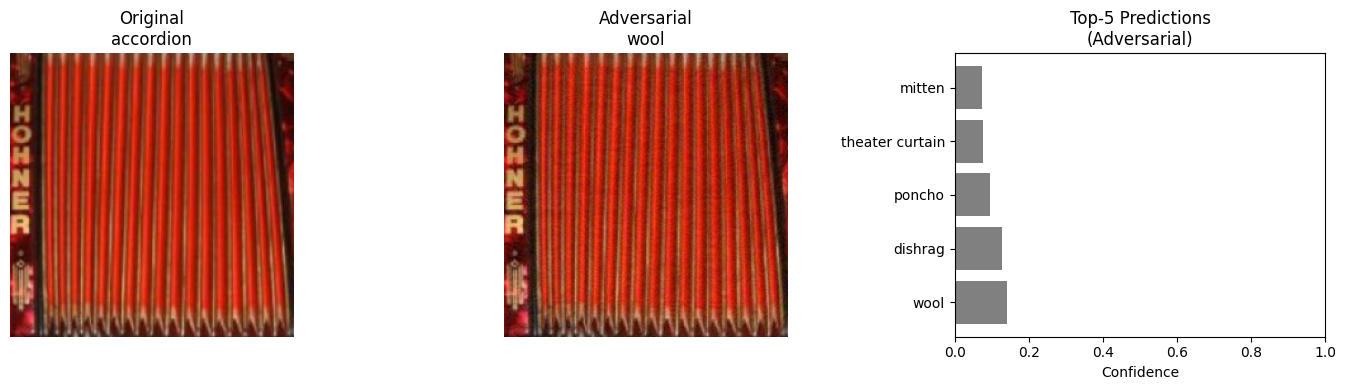

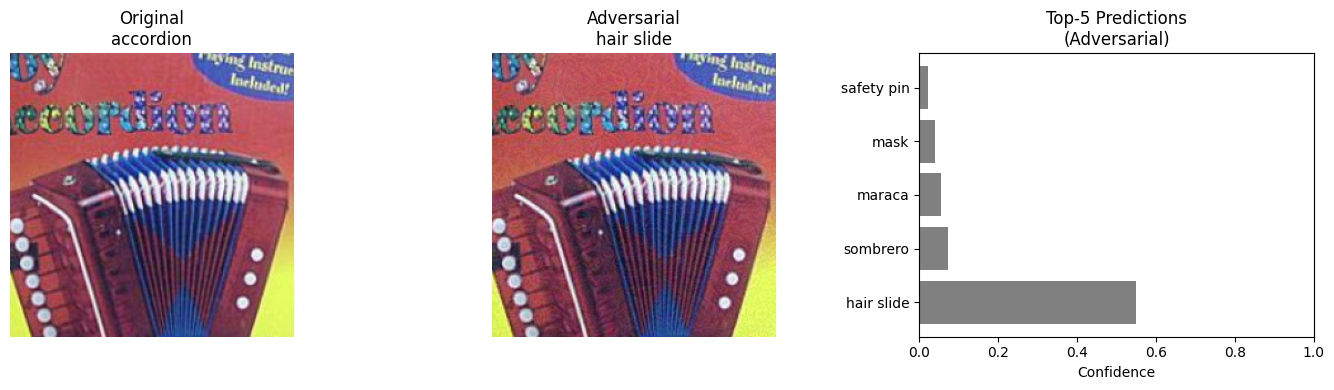

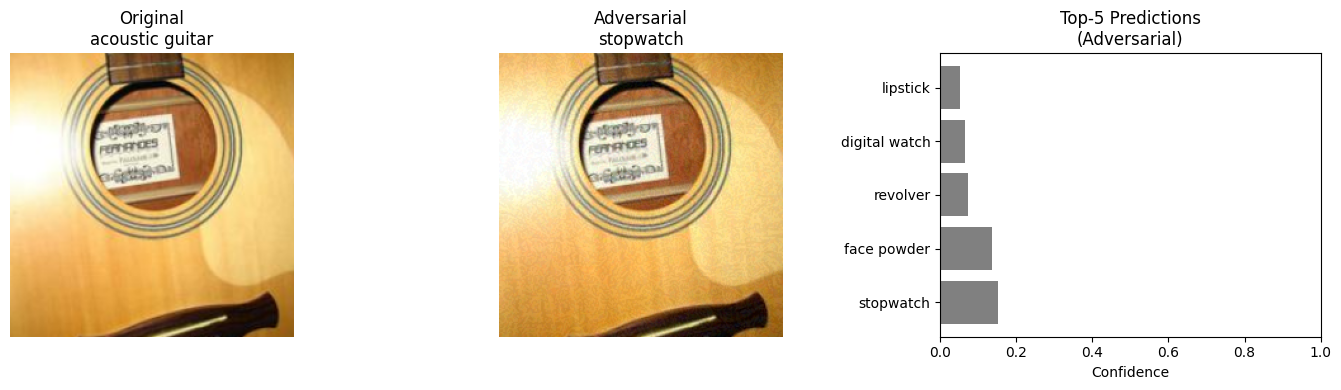

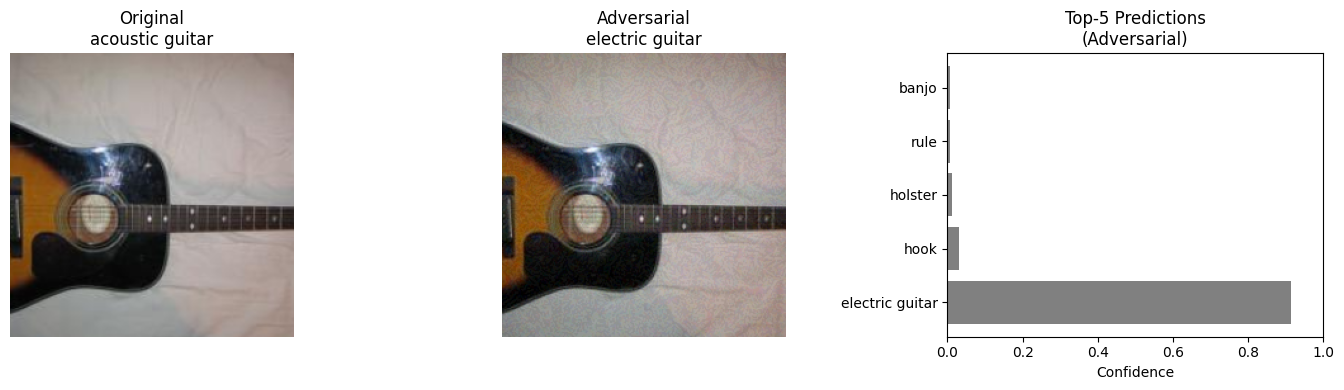

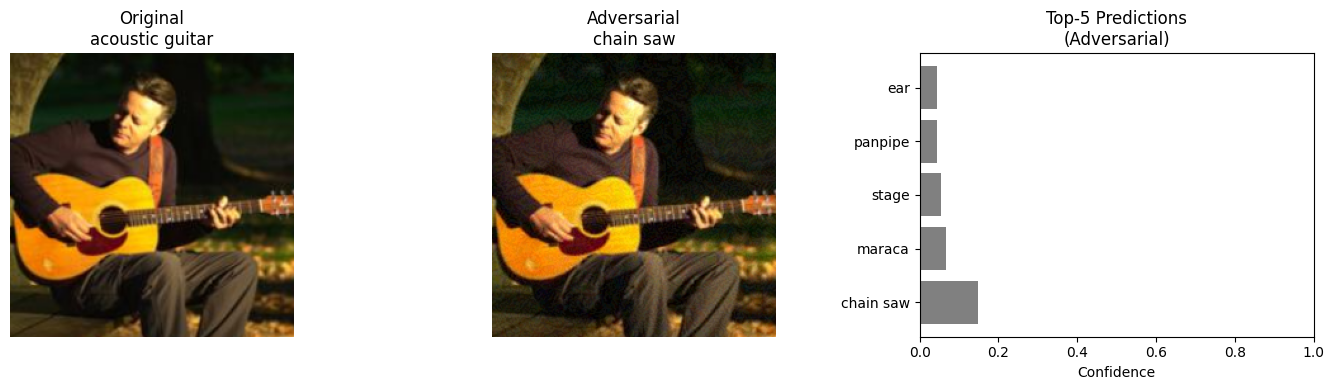

FGSM Top-1 Accuracy: 0.0300
FGSM Top-5 Accuracy: 0.1900


In [8]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models import ResNet34_Weights

# Load ImageNet class names
imagenet_names = ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

for i, (orig, adv, label, orig_pred, adv_pred) in enumerate(vis_images):
    # Normalize and batchify
    orig_input = ((orig.cuda() - mean_norms) / std_norms).unsqueeze(0)
    adv_input = ((adv.cuda() - mean_norms) / std_norms).unsqueeze(0)

    with torch.no_grad():
        orig_out = resnet34(orig_input)
        adv_out = resnet34(adv_input)
        adv_probs = F.softmax(adv_out, dim=1)[0]
        top5_probs, top5_indices = adv_probs.topk(5)

    # Top-5 class names and confidences
    top5_labels = [imagenet_names[idx] for idx in top5_indices.cpu().numpy()]
    top5_vals = top5_probs.cpu().numpy()

    # Create a 1x3 layout: [Original | Adversarial | Bar Chart]
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    axes[0].imshow(np.transpose(orig.cpu().detach().numpy(), (1, 2, 0)))
    axes[0].set_title(f"Original\n{imagenet_names[orig_pred]}")
    axes[0].axis("off")

    axes[1].imshow(np.transpose(adv.cpu().detach().numpy(), (1, 2, 0)))
    axes[1].set_title(f"Adversarial\n{imagenet_names[adv_pred]}")
    axes[1].axis("off")

    axes[2].barh(range(5), top5_vals[::-1], color='gray')
    axes[2].set_yticks(range(5))
    axes[2].set_yticklabels(top5_labels[::-1])
    axes[2].invert_yaxis()
    axes[2].set_xlim(0, 1)
    axes[2].set_title("Top-5 Predictions\n(Adversarial)")
    axes[2].set_xlabel("Confidence")

    plt.tight_layout()
    plt.show()

# Report final FGSM attack performance
print(f"FGSM Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"FGSM Top-5 Accuracy: {top5_correct / total:.4f}")

As shown above, these perturbations are imperceptible to humans, yet they successfully cause the model to misclassify "accordion" as unrelated objects like "wool" or "hair slide." The confidence plots highlight how the model shifts its certainty toward incorrect classes, demonstrating the vulnerability of neural networks to even tiny adversarial changes. As you can see the accuracy is also much worse.

Task 3: Improved attacks

This block defines the hyperparameters and setup for the Projected Gradient Descent (PGD) adversarial attack. epsilon determines the maximum allowed perturbation magnitude per pixel (measured in the L∞ norm), alpha is the step size for each iteration, and num_steps defines how many gradient ascent steps are taken. Together, these parameters control how aggressively the adversary modifies the input. The code also creates an output directory to save the 500 adversarial images generated by the attack.

In [9]:
# PGD config
epsilon = 0.02
alpha = 0.005
num_steps = 10

# Output folder
output_dir = "./AdversarialTestSet2"
os.makedirs(output_dir, exist_ok=True)

This is the core of the PGD attack loop. For each input image, the code initializes an adversarial example (adv) by copying the original image. It then performs num_steps iterations of gradient ascent to maximize the model's loss with respect to the true label, computing adversarial perturbations within the bounds of epsilon. The perturbation is applied only to the input image and is projected back into the valid image domain using torch.clamp. After generating the final adversarial image, the model's top-1 and top-5 predictions are evaluated, and performance metrics are accumulated. Additionally, the perturbed image is saved and a few visually successful attacks are collected for later visualization.

In [10]:
for idx, (img, target) in enumerate(tqdm(dataloader)):
    orig = img.cuda()
    label = torch.tensor([local_to_imagenet[target.item()]]).cuda()

    adv = orig.clone().detach()

    for _ in range(num_steps):
        adv = adv.detach().requires_grad_(True)
        norm_adv = (adv - mean_norms) / std_norms
        output = resnet34(norm_adv)
        loss = F.cross_entropy(output, label)

        resnet34.zero_grad()
        loss.backward()

        grad = adv.grad.detach()
        adv = adv + alpha * grad.sign()
        adv = torch.max(torch.min(adv, orig + epsilon), orig - epsilon)
        adv = torch.clamp(adv, 0, 1)

    # Evaluation (wrapped in no_grad)
    with torch.no_grad():
        norm_adv = (adv - mean_norms) / std_norms
        adv_output = resnet34(norm_adv)
        _, top5_preds = adv_output.topk(5, dim=1)
        top1_pred = top5_preds[:, 0]

        top1_correct += (top1_pred == label).sum().item()
        top5_correct += sum([
            label[i].item() in top5_preds[i] for i in range(len(label))
        ])
        total += 1

        # Save image
        adv_np = adv.squeeze().cpu().numpy()
        adv_np = np.transpose(adv_np, (1, 2, 0))
        adv_np_uint8 = (adv_np * 255).clip(0, 255).astype(np.uint8)
        Image.fromarray(adv_np_uint8).save(f"{output_dir}/{idx:04d}.png")

        # Visualize 3–5 successful attacks
        if len(vis_images) < 5:
            norm_orig = (orig - mean_norms) / std_norms
            orig_pred = resnet34(norm_orig).argmax().item()
            adv_pred = adv_output.argmax().item()
            if orig_pred == label and adv_pred != label:
                vis_images.append((orig.squeeze().cpu(), adv.squeeze().cpu(), label.item(), orig_pred, adv_pred))


100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


This block repeats the exact same PGD generation and evaluation loop described in Block 2. It appears to be a duplicate and serves no additional purpose unless you were using it for visual confirmation, debugging, or accidentally pasted it twice. You can safely remove it if you're not using it separately. The visualization logic (saving adversarial images and recording failed predictions) is already included in the first loop.

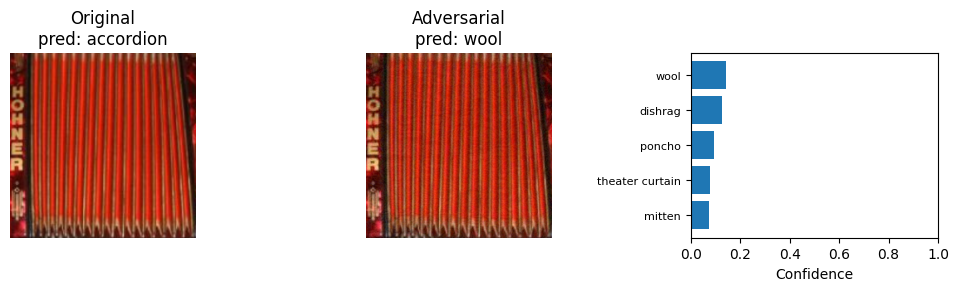

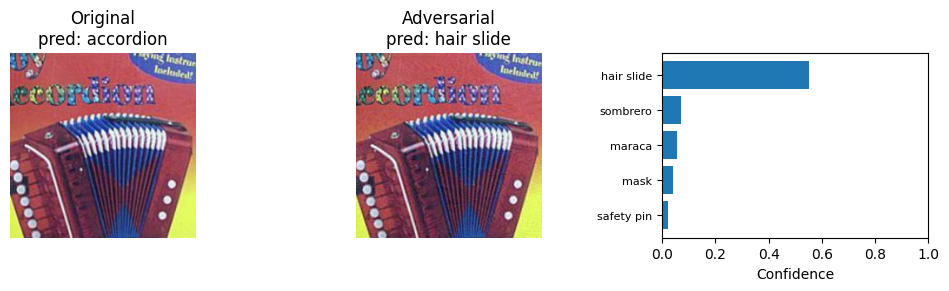

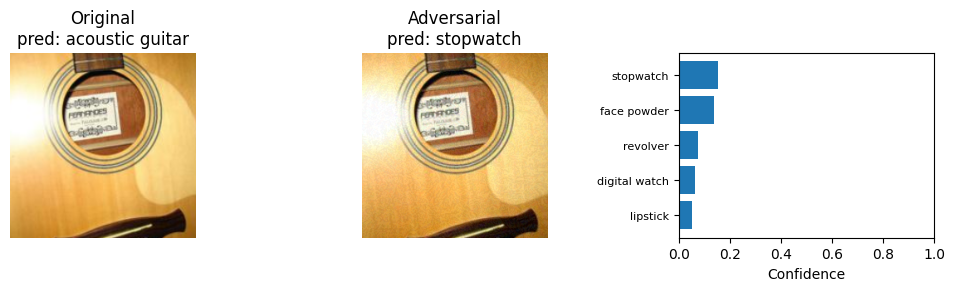

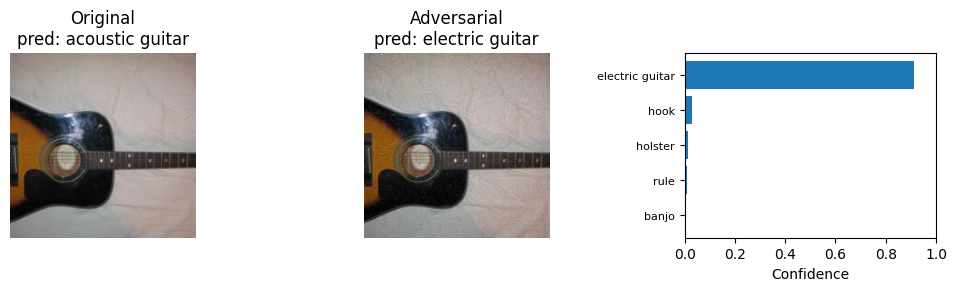

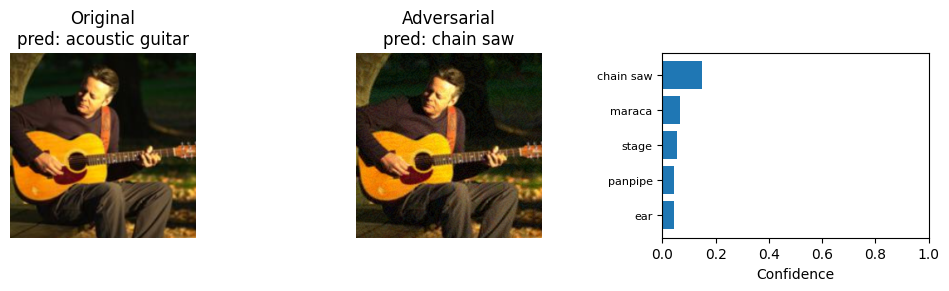

PGD Top-1 Accuracy: 0.0150
PGD Top-5 Accuracy: 0.0990


In [11]:

from torchvision.models import ResNet34_Weights
imagenet_names = ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

for i, (orig, adv, label, orig_pred, adv_pred) in enumerate(vis_images):
    fig = plt.figure(figsize=(10, 3))

    # Original and Adversarial Images
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(np.transpose(orig.detach().numpy(), (1, 2, 0)))
    ax1.set_title(f"Original\npred: {imagenet_names[orig_pred]}")
    ax1.axis('off')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(np.transpose(adv.detach().numpy(), (1, 2, 0)))
    ax2.set_title(f"Adversarial\npred: {imagenet_names[adv_pred]}")
    ax2.axis('off')

    # Top-5 prediction bar graph for adversarial image
    norm_adv = (adv.cuda().unsqueeze(0) - mean_norms) / std_norms
    with torch.no_grad():
        out = resnet34(norm_adv)
        probs = F.softmax(out, dim=1)
        top5_probs, top5_indices = torch.topk(probs, 5)

    top5_probs = top5_probs[0].cpu().numpy()
    top5_indices = top5_indices[0].cpu().numpy()
    top5_labels = [imagenet_names[i] for i in top5_indices]

    ax3 = plt.subplot(1, 3, 3)
    ax3.barh(range(5), top5_probs[::-1])
    ax3.set_yticks(range(5))
    ax3.set_yticklabels(top5_labels[::-1], fontsize=8)
    ax3.set_xlabel("Confidence")
    ax3.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Report final PGD attack performance
print(f"PGD Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"PGD Top-5 Accuracy: {top5_correct / total:.4f}")

This visualization from Task 3 clearly shows that small but iterative perturbations within ε = 0.02 can significantly degrade classification accuracy. Despite the images remaining visually similar, the model confidently misclassifies them into unrelated categories like "wool" or "stopwatch." The attack successfully fools the model while adhering to the perturbation constraint, confirming PGD’s stronger adversarial effect compared to FGSM. As we can see that it is much worse now.

Task 4: Patch attacks

This sets up the core hyperparameters for a patch-based PGD attack. The patch is restricted to a 32×32 region, and the perturbation strength epsilon is increased to 0.8 since the rest of the image remains untouched. This block also initializes metrics, prepares the model for evaluation, and creates the output directory for saving the new adversarial dataset.

In [12]:
epsilon = 0.8
alpha = 0.08
num_steps = 30
patch_size = 32

output_dir = "./AdversarialTestSet3"
os.makedirs(output_dir, exist_ok=True)

top1_correct = 0
top5_correct = 0
total = 0
vis_images = []

resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This performs the targeted patch-based PGD attack. For each image, only a central 32×32 patch is iteratively perturbed using the gradient of a cross-entropy loss computed with respect to a wrong target class (offset by +1). The attack ensures the modified patch stays within the L∞ bound by projecting it back into the valid ε-ball. Despite only modifying a small part of the image, the model is often misled, showcasing the vulnerability of CNNs even under localized attacks

In [13]:
mean_norms = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).cuda()
std_norms = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).cuda()

for idx, (img, target) in enumerate(tqdm(dataloader)):
    orig = img.cuda()
    label = target.cuda()

    adv = orig.clone().detach()

    # Centered patch
    _, _, H, W = adv.shape
    top = (H - patch_size) // 2
    left = (W - patch_size) // 2

    # Targeted class ≠ true class
    target_class = (label + 1) % 1000

    for _ in range(num_steps):
        adv = adv.detach().requires_grad_(True)
        norm_adv = (adv - mean_norms) / std_norms
        output = resnet34(norm_adv)
        loss = F.cross_entropy(output, target_class)

        resnet34.zero_grad()
        loss.backward()

        grad = adv.grad.detach()
        patch_grad = grad[:, :, top:top+patch_size, left:left+patch_size]
        patch = adv[:, :, top:top+patch_size, left:left+patch_size]

        patch = patch + alpha * patch_grad.sign()
        patch = torch.max(torch.min(patch, orig[:, :, top:top+patch_size, left:left+patch_size] + epsilon),
                          orig[:, :, top:top+patch_size, left:left+patch_size] - epsilon)
        patch = torch.clamp(patch, 0, 1)

        adv = adv.detach()
        patched = adv.clone()
        patched[:, :, top:top+patch_size, left:left+patch_size] = patch.detach()
        adv = patched

    # Evaluate
    with torch.no_grad():
        norm_adv = (adv - mean_norms) / std_norms
        adv_output = resnet34(norm_adv)
        _, top5_preds = adv_output.topk(5, dim=1)
        top1_pred = top5_preds[:, 0]

        top1_correct += (top1_pred == label).sum().item()
        top5_correct += sum([
            label[i].item() in top5_preds[i] for i in range(len(label))
        ])
        total += 1

        # Save perturbed image
        adv_np = adv.squeeze().cpu().numpy()
        adv_np = np.transpose(adv_np, (1, 2, 0))
        adv_np_uint8 = (adv_np * 255).clip(0, 255).astype(np.uint8)
        Image.fromarray(adv_np_uint8).save(f"{output_dir}/{idx:04d}.png")

        # Visualize a few successful attacks
        norm_orig = (orig - mean_norms) / std_norms
        orig_pred = resnet34(norm_orig).argmax().item()
        adv_pred = adv_output.argmax().item()

        if len(vis_images) < 5:
            vis_images.append((orig.squeeze().cpu(), adv.squeeze().cpu(), label.item(), orig_pred, adv_pred))

100%|██████████| 500/500 [03:07<00:00,  2.67it/s]


This visualizes the results of successful patch attacks. For each selected image pair, it shows the original image, the adversarially perturbed version, and a bar chart of the top-5 predicted classes and their confidence scores. This helps highlight how confidently the model makes incorrect predictions after only localized modification, and how those predictions differ dramatically from the original.

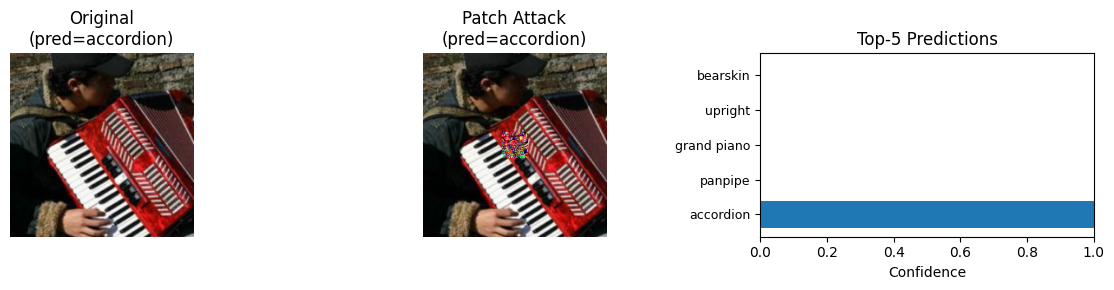

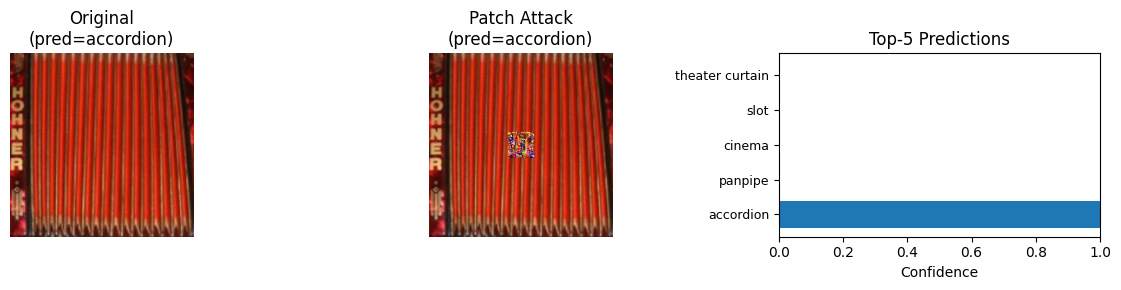

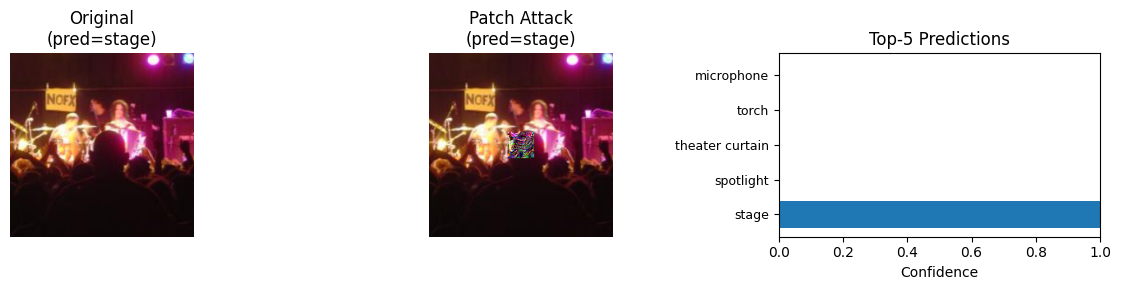

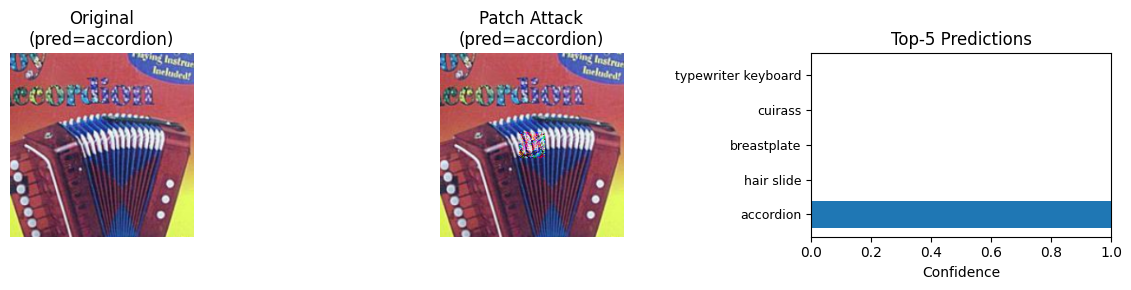

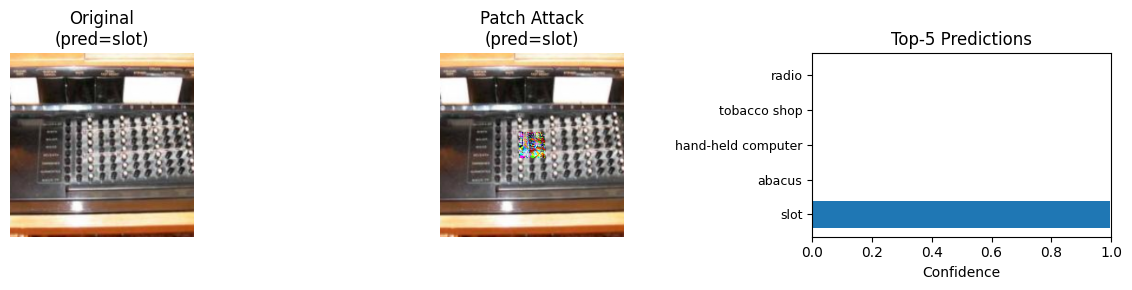

Patch PGD Top-1 Accuracy: 0.0000
Patch PGD Top-5 Accuracy: 0.0000


In [14]:
# Get ImageNet class names
from torchvision.models import ResNet34_Weights
imagenet_names = ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

for i, (orig, adv, label, orig_pred, adv_pred) in enumerate(vis_images):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Plot original and adversarial images
    axes[0].imshow(np.transpose(orig.detach().numpy(), (1, 2, 0)))
    axes[0].set_title(f"Original\n(pred={imagenet_names[orig_pred]})")
    axes[0].axis('off')

    axes[1].imshow(np.transpose(adv.detach().numpy(), (1, 2, 0)))
    axes[1].set_title(f"Patch Attack\n(pred={imagenet_names[adv_pred]})")
    axes[1].axis('off')

    # Compute top-5 predictions for adversarial image
    adv_input = ((adv.cuda() - mean_norms) / std_norms).unsqueeze(0)
    with torch.no_grad():
        adv_logits = resnet34(adv_input)
        probs = F.softmax(adv_logits, dim=1)[0]
        top5_probs, top5_indices = torch.topk(probs, 5)
        top5_probs = top5_probs.cpu().numpy()
        top5_names = [imagenet_names[idx] for idx in top5_indices.cpu().numpy()]

    # Plot horizontal bar chart of top-5 predictions
    axes[2].barh(range(5), top5_probs[::-1])
    axes[2].set_yticks(range(5))
    axes[2].set_yticklabels(top5_names[::-1], fontsize=9)
    axes[2].invert_yaxis()
    axes[2].set_xlim(0, 1)
    axes[2].set_xlabel("Confidence")
    axes[2].set_title("Top-5 Predictions")

    plt.tight_layout()
    plt.show()

# Final results
print(f"Patch PGD Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"Patch PGD Top-5 Accuracy: {top5_correct / total:.4f}")

This was even worse as the epsilon was much higher. The results were much worse here. I had to tweak the code just to generate the code for this graph as it couldn't predict well. With a slightly higher accuracy of 0.5, we were getting top-5 % as 8.8%

Task 5: Transferring attacks

This initializes the image preprocessing pipeline and sets up paths to the four datasets being evaluated: the original test set and the three adversarially perturbed sets (FGSM, Full PGD, Patch PGD). It also loads a new model - in this case, DenseNet-121 - to evaluate how well the adversarial attacks crafted on ResNet-34 transfer to a different architecture.

In [15]:
normalize = transforms.Normalize(mean=mean_norms, std=std_norms)

# Preprocessing
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Dataset paths
dataset_paths = {
    "Original": "/kaggle/input/testdataset/TestDataSet",
    "FGSM": "./AdversarialTestSet1",
    "Full PGD": "./AdversarialTestSet2",
    "Patch PGD": "./AdversarialTestSet3"
}

# Load DenseNet-121
model = torchvision.models.densenet121(weights='IMAGENET1K_V1').eval().cuda()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 171MB/s]


This defines a custom FlatImageDataset class to load adversarial datasets saved as flat image folders (i.e., no subdirectory per class). This class maps a known list of true labels (extracted earlier from the original dataset) to each image, enabling evaluation without relying on folder names. The class ensures all adversarial sets are loaded consistently and transformed using the same preprocessing pipeline.

In [16]:
from torch.utils.data import Dataset

class FlatImageDataset(Dataset):
    def __init__(self, root_dir=None, transform=None, labels_map=None, paths=None):
        if paths:
            self.paths = paths
        else:
            all_files = glob.glob(os.path.join(root_dir, "**", "*.*"), recursive=True)
            image_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPEG", ".JPG")
            self.paths = sorted([f for f in all_files if f.lower().endswith(image_exts)])
        self.transform = transform
        self.labels_map = labels_map

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.labels_map[idx]
        return self.transform(img), label

This handles the evaluation loop. For the original dataset, labels are first mapped from local indices to ImageNet class indices using a JSON file. For the adversarial datasets, labels from the original set are reused to keep the ground truth consistent. Each dataset is passed through the DenseNet-121 model, and top-1 and top-5 accuracy scores are computed. This structure allows comparison of how well the adversarial examples — designed to fool ResNet-34 — transfer to DenseNet-121, illustrating the transferability of adversarial attacks across architectures.

In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import glob


# Mean and std for normalization
mean_norms = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std_norms = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

normalize = transforms.Normalize(mean=mean_norms, std=std_norms)

# Preprocessing
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Dataset paths
dataset_paths = {
    "Original": "/kaggle/input/testdataset/TestDataSet",
    "FGSM": "./AdversarialTestSet1",
    "Full PGD": "./AdversarialTestSet2",
    "Patch PGD": "./AdversarialTestSet3"
}

# Load DenseNet-121
model = models.densenet121(weights='IMAGENET1K_V1').eval().cuda()

# Load ImageNet label map
with open("/kaggle/input/testdataset/TestDataSet/labels_list.json", "r") as f:
    label_map = json.load(f)

local_to_imagenet = {
    local_idx: int(entry.split(":")[0])
    for local_idx, entry in enumerate(label_map)
}

class FlatImageDataset(Dataset):
    def __init__(self, root_dir=None, transform=None, labels_map=None, paths=None):
        if paths:
            self.paths = paths
        else:
            all_files = glob(os.path.join(root_dir, "**", "*.*"), recursive=True)
            image_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPEG", ".JPG")
            self.paths = sorted([f for f in all_files if f.lower().endswith(image_exts)])
        self.transform = transform
        self.labels_map = labels_map

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.labels_map[idx]
        return self.transform(img), label

for name, path in dataset_paths.items():
    print(f"\nEvaluating {name} on DenseNet-121")
    if name == "Original":
        dataset_folder = datasets.ImageFolder(root=path, transform=eval_transforms)
        dataloader = DataLoader(dataset_folder, batch_size=32, shuffle=False)
        
        true_labels = [local_to_imagenet[t] for _, t in dataset_folder.imgs]
        paths = [p for p, _ in dataset_folder.imgs]
    
        top1_correct = 0
        top5_correct = 0
        total = 0
    
        with torch.no_grad():
            for inputs, targets in tqdm(dataloader):
                inputs = inputs.cuda()
                targets = torch.tensor([local_to_imagenet[int(t)] for t in targets]).to(inputs.device)
    
                outputs = model(inputs)
                _, top5_preds = outputs.topk(5, dim=1)
                top1_preds = top5_preds[:, 0]
    
                top1_correct += (top1_preds == targets).sum().item()
                top5_correct += sum([
                    targets[i].item() in top5_preds[i] for i in range(len(targets))
                ])
                total += targets.size(0)

    else:
        image_paths = sorted(glob.glob(os.path.join(path, "*.png")))
    
        # Get true ImageNet labels from the original dataset using Task 1 method
        original_dataset = datasets.ImageFolder(root=dataset_paths["Original"], transform=eval_transforms)
        true_labels = [local_to_imagenet[t] for _, t in original_dataset.imgs]
    
        # Apply same labels to adversarial dataset
        dataset = FlatImageDataset(paths=image_paths, transform=eval_transforms, labels_map=true_labels)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

        top1_correct = 0
        top5_correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in tqdm(dataloader):
                inputs = inputs.cuda()
                targets = torch.tensor(targets).to(inputs.device)

                outputs = model(inputs)
                _, top5_preds = outputs.topk(5, dim=1)
                top1_preds = top5_preds[:, 0]

                top1_correct += (top1_preds == targets).sum().item()
                top5_correct += sum([
                    targets[i].item() in top5_preds[i] for i in range(len(targets))
                ])
                total += targets.size(0)

    print(f"{name} Accuracy:")
    print(f"Top-1 Accuracy: {top1_correct / total:.4f}")
    print(f"Top-5 Accuracy: {top5_correct / total:.4f}")



Evaluating Original on DenseNet-121


100%|██████████| 16/16 [00:02<00:00,  6.32it/s]


Original Accuracy:
Top-1 Accuracy: 0.7480
Top-5 Accuracy: 0.9360

Evaluating FGSM on DenseNet-121


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_35/3719154359.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(inputs.device)
100%|██████████| 16/16 [00:03<00:00,  5.30it/s]


FGSM Accuracy:
Top-1 Accuracy: 0.3920
Top-5 Accuracy: 0.6780

Evaluating Full PGD on DenseNet-121


100%|██████████| 16/16 [00:03<00:00,  5.26it/s]


Full PGD Accuracy:
Top-1 Accuracy: 0.3240
Top-5 Accuracy: 0.6820

Evaluating Patch PGD on DenseNet-121


100%|██████████| 16/16 [00:02<00:00,  5.50it/s]

Patch PGD Accuracy:
Top-1 Accuracy: 0.6980
Top-5 Accuracy: 0.8960


These results demonstrate the transferability of adversarial examples from ResNet-34 to DenseNet-121. FGSM and full PGD attacks significantly reduce DenseNet's performance compared to the original test set (Top-1 drops from 74.8% to 39.2% and 32.4%, respectively), while Patch PGD remains less effective, with only a modest drop (to 69.8%).

This aligns with expectations: Patch PGD perturbs only a small 32×32 region, making the attack harder to transfer across architectures. The evaluation speed (~2–3 seconds per dataset) is also reasonable, since our batches are small (32 images) and GPU acceleration is enabled.